# NYC Shootings Cluster Analysis
This model clusters data of shooting incidents in New York City based on relevant attributes such as occurrence date and time, location, demographic information of perpetrators and victims, and jurisdiction
- dataset: NYPD_Shooting_Incident_Data__Historic_.csv

In [36]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import dill
import cloudpickle
import os
import warnings
# settings
SESSION_FILE = "variables.session"
def save_session():
    dill.dump_session(SESSION_FILE)
    print(f"Session saved to {SESSION_FILE}")
def load_session():
    if os.path.exists(SESSION_FILE):
        dill.load_session(SESSION_FILE)
        print(f"Session loaded from {SESSION_FILE}")
    else:
        print("No saved session found.")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)

In [37]:
# load everything
load_session()

Session loaded from variables.session


In [38]:
# load dataset
data = pd.read_csv("NYPD_Shooting_Incident_Data__Historic_.csv")
data.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,NaN,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


In [39]:
# data backup
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             27312 non-null  int64  
 1   OCCUR_DATE               27312 non-null  object 
 2   OCCUR_TIME               27312 non-null  object 
 3   BORO                     27312 non-null  object 
 4   LOC_OF_OCCUR_DESC        1716 non-null   object 
 5   PRECINCT                 27312 non-null  int64  
 6   JURISDICTION_CODE        27310 non-null  float64
 7   LOC_CLASSFCTN_DESC       1716 non-null   object 
 8   LOCATION_DESC            12335 non-null  object 
 9   STATISTICAL_MURDER_FLAG  27312 non-null  bool   
 10  PERP_AGE_GROUP           17968 non-null  object 
 11  PERP_SEX                 18002 non-null  object 
 12  PERP_RACE                18002 non-null  object 
 13  VIC_AGE_GROUP            27312 non-null  object 
 14  VIC_SEX               

# Data Preprocessing

In [40]:
# null values
df.isnull().sum()

INCIDENT_KEY                   0
OCCUR_DATE                     0
OCCUR_TIME                     0
BORO                           0
LOC_OF_OCCUR_DESC          25596
PRECINCT                       0
JURISDICTION_CODE              2
LOC_CLASSFCTN_DESC         25596
LOCATION_DESC              14977
STATISTICAL_MURDER_FLAG        0
PERP_AGE_GROUP              9344
PERP_SEX                    9310
PERP_RACE                   9310
VIC_AGE_GROUP                  0
VIC_SEX                        0
VIC_RACE                       0
X_COORD_CD                     0
Y_COORD_CD                     0
Latitude                      10
Longitude                     10
Lon_Lat                       10
dtype: int64

In [41]:
# dropping irrelevant columns
df.drop(columns= ['INCIDENT_KEY', 'LOC_CLASSFCTN_DESC', 'LOC_OF_OCCUR_DESC'], inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OCCUR_DATE               27312 non-null  object 
 1   OCCUR_TIME               27312 non-null  object 
 2   BORO                     27312 non-null  object 
 3   PRECINCT                 27312 non-null  int64  
 4   JURISDICTION_CODE        27310 non-null  float64
 5   LOCATION_DESC            12335 non-null  object 
 6   STATISTICAL_MURDER_FLAG  27312 non-null  bool   
 7   PERP_AGE_GROUP           17968 non-null  object 
 8   PERP_SEX                 18002 non-null  object 
 9   PERP_RACE                18002 non-null  object 
 10  VIC_AGE_GROUP            27312 non-null  object 
 11  VIC_SEX                  27312 non-null  object 
 12  VIC_RACE                 27312 non-null  object 
 13  X_COORD_CD               27312 non-null  float64
 14  Y_COORD_CD            

In [42]:
# dropping irrelevant data
df = df.drop(df[(df['PERP_AGE_GROUP'] == '940') | (df['PERP_AGE_GROUP'] == '224') | (df['PERP_AGE_GROUP'] == '1020') | (df['VIC_AGE_GROUP'] == '1022')].index)
print(f'no of rows reuced to {df.shape[0]}')

no of rows reuced to 27308


In [43]:
# Duplicates
df[df.duplicated()]

,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat


In [44]:
# Extract year, month, day, hour, and minute
df['OCCUR_DATETIME'] = pd.to_datetime(df['OCCUR_DATE'].astype(str) + ' ' + df['OCCUR_TIME'].astype(str))
df['year'] = df['OCCUR_DATETIME'].dt.year
df['month'] = df['OCCUR_DATETIME'].dt.month
df['day'] = df['OCCUR_DATETIME'].dt.day
df['hour'] = df['OCCUR_DATETIME'].dt.hour
df['minute'] = df['OCCUR_DATETIME'].dt.minute
df.drop(columns= ['OCCUR_DATE', 'OCCUR_TIME', 'OCCUR_DATETIME'], inplace= True)
df.head()

,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,year,month,day,hour,minute
0,QUEENS,105,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025),2021,5,27,21,30
1,BRONX,40,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006),2014,6,27,17,40
2,QUEENS,108,0.0,NaN,True,NaN,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004),2015,11,21,3,56
3,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003),2015,10,9,18,30
4,BRONX,47,0.0,NaN,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006),2009,2,19,22,58


In [45]:
# Changing Lon_Lat column
df[['LON_GEO', 'LAT_GEO']] = df['Lon_Lat'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)').astype(float)
df.drop(columns=['Lon_Lat'], inplace= True)
df.head()

,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month,day,hour,minute,LON_GEO,LAT_GEO
0,QUEENS,105,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,2021,5,27,21,30,-73.730839,40.662965
1,BRONX,40,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,2014,6,27,17,40,-73.924942,40.810352
2,QUEENS,108,0.0,NaN,True,NaN,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,2015,11,21,3,56,-73.915492,40.742607
3,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,2015,10,9,18,30,-73.919457,40.837782
4,BRONX,47,0.0,NaN,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,2009,2,19,22,58,-73.852910,40.886238


In [46]:
# numeric and non numeric columns
non_numeric_columns = df.select_dtypes(include= ['object', 'bool']).columns.to_list()
numeric_columns = df.select_dtypes(exclude= ['object', 'bool']).columns.to_list()
print(f'non numeric columns: {non_numeric_columns}')
print(f'numeric columns: {numeric_columns}')

non numeric columns: ['BORO', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']
numeric columns: ['PRECINCT', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'year', 'month', 'day', 'hour', 'minute', 'LON_GEO', 'LAT_GEO']


In [47]:
# filling null values
df['JURISDICTION_CODE'].fillna(df['JURISDICTION_CODE'].mode()[0], inplace=True)
for i in numeric_columns:
    df[i].fillna(round(df[i].mean(), 2), inplace=True)
for i in non_numeric_columns:
    df[i].fillna(df[i].mode()[0], inplace=True)
    mode_val = df.loc[df[i] != '(null)', i].mode()
    if not mode_val.empty:
        df[i] = df[i].replace('(null)', mode_val[0])
df.head()

,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month,day,hour,minute,LON_GEO,LAT_GEO
0,QUEENS,105,0.0,MULTI DWELL - PUBLIC HOUS,False,18-24,M,BLACK,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,2021,5,27,21,30,-73.730839,40.662965
1,BRONX,40,0.0,MULTI DWELL - PUBLIC HOUS,False,18-24,M,BLACK,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,2014,6,27,17,40,-73.924942,40.810352
2,QUEENS,108,0.0,MULTI DWELL - PUBLIC HOUS,True,18-24,M,BLACK,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,2015,11,21,3,56,-73.915492,40.742607
3,BRONX,44,0.0,MULTI DWELL - PUBLIC HOUS,False,18-24,M,BLACK,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,2015,10,9,18,30,-73.919457,40.837782
4,BRONX,47,0.0,MULTI DWELL - PUBLIC HOUS,True,25-44,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,2009,2,19,22,58,-73.852910,40.886238


In [48]:
# outliers
df.describe()

,PRECINCT,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month,day,hour,minute,LON_GEO,LAT_GEO
count,27308.000000,27308.000000,2.730800e+04,27308.000000,27308.000000,27308.000000,27308.000000,27308.000000,27308.000000,27308.000000,27308.000000,27308.000000,27308.000000
mean,65.637982,0.326864,1.009449e+06,208124.865512,40.737886,-73.909051,2013.492273,6.825546,15.930973,12.223085,28.159184,-73.909051,40.737886
std,27.304809,0.737698,1.837847e+04,31886.586417,0.087510,0.066262,5.143153,3.128870,8.931765,8.486168,17.488024,0.066262,0.087510
min,1.000000,0.000000,9.149281e+05,125756.718750,40.511586,-74.249303,2006.000000,1.000000,1.000000,0.000000,0.000000,-74.249303,40.511586
25%,44.000000,0.000000,1.000029e+06,182832.343750,40.668481,-73.943000,2009.000000,5.000000,8.000000,3.000000,14.000000,-73.943000,40.668481
50%,68.000000,0.000000,1.007731e+06,194478.093750,40.700331,-73.915210,2013.000000,7.000000,16.000000,15.000000,29.000000,-73.915210,40.700331
75%,81.000000,0.000000,1.016838e+06,239518.468750,40.824066,-73.882330,2018.000000,9.000000,24.000000,20.000000,44.000000,-73.882330,40.824066
max,123.000000,2.000000,1.066815e+06,271127.687500,40.910818,-73.702046,2022.000000,12.000000,31.000000,23.000000,59.000000,-73.702046,40.910818


In [49]:
# save data
df.to_csv("NYPD_Shooting_Incident_Data__Historic_Cleaned.csv", index= False)

In [50]:
# data encoding
label = LabelEncoder()
for i in non_numeric_columns:
    df[i] = label.fit_transform(df[i])
df.head()

,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month,day,hour,minute,LON_GEO,LAT_GEO
0,3,105,0.0,24,0,0,1,2,0,1,2,1.058925e+06,180924.000000,40.662965,-73.730839,2021,5,27,21,30,-73.730839,40.662965
1,0,40,0.0,24,0,0,1,2,0,1,2,1.005028e+06,234516.000000,40.810352,-73.924942,2014,6,27,17,40,-73.924942,40.810352
2,3,108,0.0,24,1,0,1,2,1,1,5,1.007668e+06,209836.531250,40.742607,-73.915492,2015,11,21,3,56,-73.915492,40.742607
3,0,44,0.0,24,0,0,1,2,4,1,6,1.006537e+06,244511.140625,40.837782,-73.919457,2015,10,9,18,30,-73.919457,40.837782
4,0,47,0.0,24,1,1,1,2,2,1,2,1.024922e+06,262189.406250,40.886238,-73.852910,2009,2,19,22,58,-73.852910,40.886238


In [51]:
# scale dataset
scaler = StandardScaler()
df = scaler.fit_transform(df)
df

array([[ 1.60280674,  1.44160462, -0.44309464, ...,  0.10526344,
         2.68953849, -0.85616621],
       [-1.1065928 , -0.93897199, -0.44309464, ...,  0.67709379,
        -0.23983202,  0.82810399],
       [ 1.60280674,  1.55147739, -0.44309464, ...,  1.59202235,
        -0.09720583,  0.05394423],
       ...,
       [ 0.69967356, -1.23196603, -0.44309464, ...,  0.0480804 ,
        -0.4594654 ,  0.8264761 ],
       [-1.1065928 , -0.71922645,  2.26809257, ..., -1.15276333,
         0.19483143,  1.34568064],
       [-1.1065928 , -0.75585071, -0.44309464, ..., -0.80966512,
         0.93443457,  1.13379162]])

In [52]:
# dimensionality reduction
pca = PCA(n_components= 2, random_state= 42)
df = pca.fit_transform(df)
df

array([[-1.30471055,  5.20357049],
       [ 1.68524991, -0.77591196],
       [-0.88844465,  0.36456074],
       ...,
       [ 1.19057014, -0.982387  ],
       [ 2.8576128 , -0.51260614],
       [ 2.56300457,  1.16760284]])

# model training and clustering

In [53]:
# initialization
result = []

# model training
for i in range(2,101,1):
    current_result = []
    current_result.append(i)
    print(f'Training for {i} clusters')

    # training KMeans
    model = KMeans(n_clusters= i, random_state= 42)
    model.fit(df)
    current_result.append(model.inertia_)
    silhoutte = silhouette_score(df, model.labels_, random_state= 42)
    current_result.append(silhoutte)

    # storing the result
    result.append(current_result)

# further settings
print("\rmodel testing completed")
result = pd.DataFrame(result, columns= ['no of clusters', 'inertia', 'silhouette_score'])
result

Training for 2 clusters
Training for 3 clusters
Training for 4 clusters
Training for 5 clusters
Training for 6 clusters
Training for 7 clusters
Training for 8 clusters
Training for 9 clusters
Training for 10 clusters
Training for 11 clusters
Training for 12 clusters
Training for 13 clusters
Training for 14 clusters
Training for 15 clusters
Training for 16 clusters
Training for 17 clusters
Training for 18 clusters
Training for 19 clusters
Training for 20 clusters
Training for 21 clusters
Training for 22 clusters
Training for 23 clusters
Training for 24 clusters
Training for 25 clusters
Training for 26 clusters
Training for 27 clusters
Training for 28 clusters
Training for 29 clusters
Training for 30 clusters
Training for 31 clusters
Training for 32 clusters
Training for 33 clusters
Training for 34 clusters
Training for 35 clusters
Training for 36 clusters
Training for 37 clusters
Training for 38 clusters
Training for 39 clusters
Training for 40 clusters
Training for 41 clusters
Training

,no of clusters,inertia,silhouette_score
0,2,98985.404131,0.531611
1,3,48978.980447,0.621007
2,4,31138.054774,0.636033
3,5,24599.228155,0.533171
4,6,17113.227998,0.480875
...,...,...,...
94,96,852.423623,0.355527
95,97,841.844924,0.355511
96,98,831.059380,0.357575
97,99,829.856216,0.354465


Text(0.5, 1.0, 'elbow mehod')

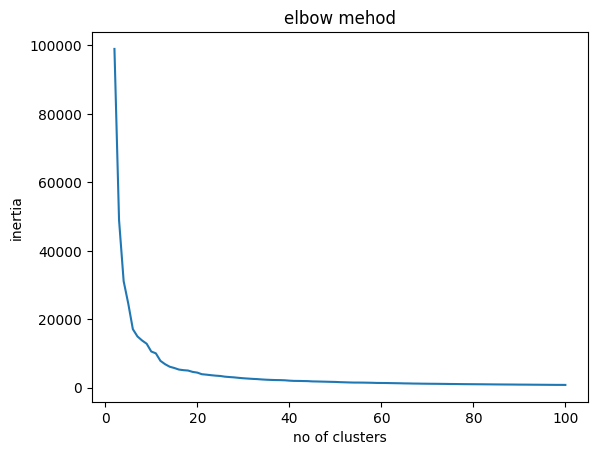

In [54]:
# plotting inertia
sns.lineplot(
    data= result,
    y= "inertia",
    x= "no of clusters",
)
plt.title("elbow mehod")

Text(0.5, 1.0, 'silhouette score')

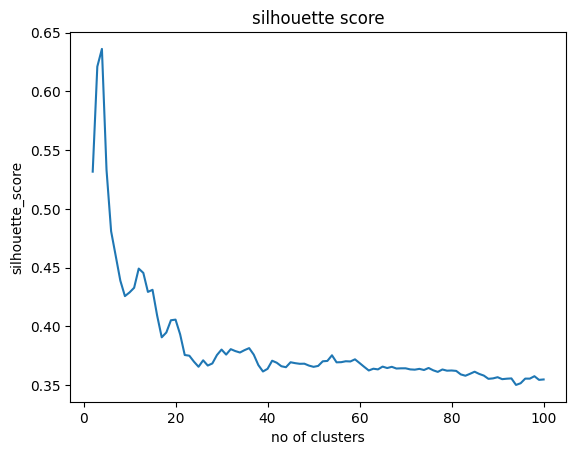

In [55]:
# plotting silhouette score
sns.lineplot(
    data= result,
    y= "silhouette_score",
    x= "no of clusters",
)
plt.title("silhouette score")

In [56]:
# finding best model
result.sort_values(by= 'silhouette_score', ascending= False, inplace= True)
best_no_of_cluster = int(result.iloc[0]['no of clusters'])
best_silhouette_score = result.iloc[0]['silhouette_score']
best_inertia = result.iloc[0]['inertia']
print("best no of cluster:", best_no_of_cluster)
print("silhoutte score for the cluster:", best_silhouette_score)
print("inertia for the cluster:", best_inertia)
result

best no of cluster: 4
silhoutte score for the cluster: 0.6360330632146993
inertia for the cluster: 31138.054773960015


,no of clusters,inertia,silhouette_score
2,4,31138.054774,0.636033
1,3,48978.980447,0.621007
3,5,24599.228155,0.533171
0,2,98985.404131,0.531611
4,6,17113.227998,0.480875
...,...,...,...
89,91,906.654180,0.355058
98,100,820.053953,0.354811
97,99,829.856216,0.354465
93,95,863.660308,0.351593


In [57]:
# model retraining and clustering
model = KMeans(n_clusters= best_no_of_cluster, random_state= 42)
model.fit(df)
cluster = model.fit_predict(df, model.labels_)
df = np.column_stack((df, cluster))
df

array([[-1.30471055,  5.20357049,  2.        ],
       [ 1.68524991, -0.77591196,  1.        ],
       [-0.88844465,  0.36456074,  0.        ],
       ...,
       [ 1.19057014, -0.982387  ,  1.        ],
       [ 2.8576128 , -0.51260614,  1.        ],
       [ 2.56300457,  1.16760284,  1.        ]])

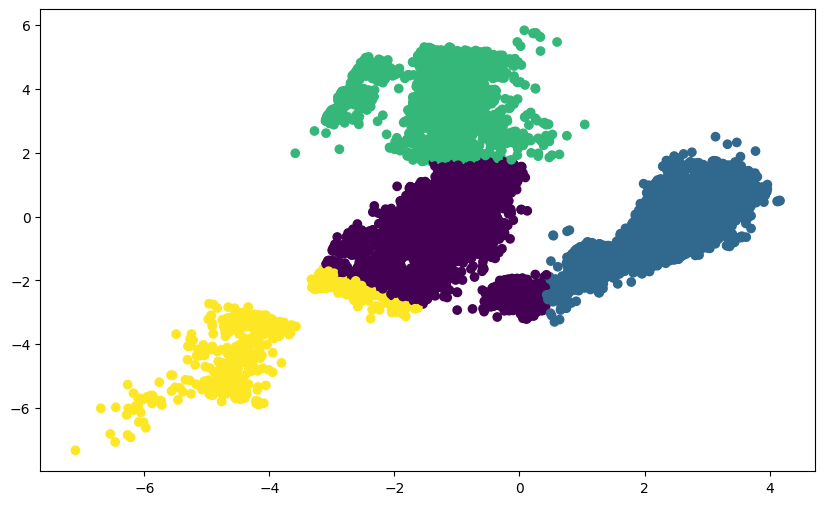

In [58]:
# visualize the clusters
plt.figure(figsize= (10,6))
plt.scatter(df[:, 0], df[:, 1], c= df[:, 2], cmap= 'viridis')
plt.show()

In [59]:
# save model
model_name = "model.pkl"
with open(model_name, 'wb') as f:
    cloudpickle.dump(model, f)
print(f'model saved as {model_name}')

model saved as model.pkl


In [60]:
# save everything
save_session()

Session saved to variables.session
